# Install Required Libraries

In [1]:
!pip install explainerdashboard shap xgboost pandas scikit-learn
!pip install dash-bootstrap-components==1.0.3 dash==2.6.2 Flask==2.2.5


  Using cached dash-2.6.2-py3-none-any.whl.metadata (11 kB)
Using cached dash-2.6.2-py3-none-any.whl (9.8 MB)
  Attempting uninstall: dash
    Found existing installation: dash 3.0.1
    Uninstalling dash-3.0.1:
      Successfully uninstalled dash-3.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.8 requires dash>=2.10.1, but you have dash 2.6.2 which is incompatible.


In [2]:
!pip uninstall pandas numpy -y

Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3


In [3]:
!pip install pandas==1.5.3 numpy==1.24.3

  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.8 requires dash>=2.10.1, but you have dash 2.6.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have num

In [4]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


# Load the dataset

In [5]:
df = pd.read_csv('Processed_data_latest.csv')

# Preview data
df.head()


,collect_scheduled_date,collect_token,pickup_date,quantity,title,unique_client,dependents_qty,household,preferred_languages,primary_contact,...,recent_returned_1m,recent_returned_3m,recent_returned_6m,missed_pickup,scheduled_but_missed,is_future_scheduled,schedule_pickup_gap_days,scheduled_month,scheduled_weekday,pickup_weekday
0,2023-11-07 04:00:00,BYF4VF,2023-11-07 15:59:00,1,Abdulhalim's Hamper,1694115474357x134699341188431870,6,yes,Arabic,1694116977541x457443885172654100,...,0,0,1,0,False,False,0.0,11,Tuesday,Tuesday
1,2023-11-13 04:00:00,UYW02H,NaN,1,food hamper,1694630813849x163939988692795400,2,yes,Turkish,1694631770190x471709318317080600,...,0,0,0,1,True,False,NaN,11,Monday,NaN
2,2023-12-13 04:00:00,9IQ2X1,NaN,1,food hamper,1694630813849x163939988692795400,2,yes,Turkish,1694631770190x471709318317080600,...,0,0,0,1,True,False,NaN,12,Wednesday,NaN
3,2024-01-13 04:00:00,89SQQE,NaN,1,food hamper,1694630813849x163939988692795400,2,yes,Turkish,1694631770190x471709318317080600,...,0,0,0,1,True,False,NaN,1,Saturday,NaN
4,2024-02-13 04:00:00,FCB9ED,NaN,1,food hamper,1694630813849x163939988692795400,2,yes,Turkish,1694631770190x471709318317080600,...,0,0,0,1,True,False,NaN,2,Tuesday,NaN


## Encoding and selecting the target features

In [6]:
# Copy dataframe to avoid issues
df_encoded = df.copy()

# Encode 'age_group' and 'scheduled_weekday' for modeling
le_age_group = LabelEncoder()
le_sched_weekday = LabelEncoder()

df_encoded['age_group_encoded'] = le_age_group.fit_transform(df_encoded['age_group'].astype(str))
df_encoded['scheduled_weekday_encoded'] = le_sched_weekday.fit_transform(df_encoded['scheduled_weekday'].astype(str))


In [7]:
trained_features = [
    'distance_km',
    'pickup_day',
    'dependents_qty',
    'age_group_encoded',
    'scheduled_month',
    'scheduled_weekday_encoded'
]

# Create X and y
X = df_encoded[trained_features]
y_1m = df_encoded['recent_returned_1m']
y_3m = df_encoded['recent_returned_3m']
y_6m = df_encoded['recent_returned_6m']


# Loading the trained models

In [8]:
# Load XGBoost models with SMOTE
with open('1m_XGBoost_smote.pkl', 'rb') as file:
    model_1m = pickle.load(file)

with open('3m_XGBoost_smote.pkl', 'rb') as file:
    model_3m = pickle.load(file)

with open('6m_XGBoost_smote.pkl', 'rb') as file:
    model_6m = pickle.load(file)


# Ngrok Auth Setup and create XAI dashboard

In [9]:
!pip install pyngrok


In [10]:
!ngrok config add-authtoken 2uYd1ZZ7AT36iu5eEi8DzMj1dgy_4zodWGk9PSBVw3mhEDXcf

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## One month prediction model

In [16]:
from pyngrok import ngrok
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Open tunnel (after setting the authtoken)
public_url = ngrok.connect(8050)
print("Public URL:", public_url)

# Create the explainer for 1-month model # This line was missing
explainer_1m = ClassifierExplainer(
    model_1m,
    X,
    y_1m,
    model_output='logodds'
)

# Run the dashboard
ExplainerDashboard(
    explainer_1m,
    title="Client Return Prediction - 1 Month",
    port=8050
).run()

Public URL: NgrokTunnel: "https://a8be-34-170-144-151.ngrok-free.app" -> "http://localhost:8050"
Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs

<IPython.core.display.Javascript object>

## Three month prediction model

In [17]:
# Create the explainer for 3-month model
explainer_3m = ClassifierExplainer(
    model_3m,
    X,
    y_3m,
    model_output='logodds'
)

# Start the ngrok tunnel for port 8051
public_url_3m = ngrok.connect(8051)
print("3-Month Dashboard URL:", public_url_3m)

# Run the dashboard on port 8051
ExplainerDashboard(
    explainer_3m,
    title="Client Return Prediction - 3 Months",
    port=8051
).run()


Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
3-Month Dashboard URL: NgrokTunnel: "https://a5f7-34-170-144-151.ngrok-free.app" -> "http://localhost:8051"
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try set

<IPython.core.display.Javascript object>

## Six month prediction model

In [15]:
# Create the explainer for 6-month model
explainer_6m = ClassifierExplainer(
    model_6m,
    X,
    y_6m,
    model_output='logodds'
)

# Start the ngrok tunnel for port 8052
public_url_6m = ngrok.connect(8052)
print("6-Month Dashboard URL:", public_url_6m)

# Run the dashboard on port 8052
ExplainerDashboard(
    explainer_6m,
    title="Client Return Prediction - 6 Months",
    port=8052
).run()


Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
6-Month Dashboard URL: NgrokTunnel: "https://ad15-34-170-144-151.ngrok-free.app" -> "http://localhost:8052"
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try set

<IPython.core.display.Javascript object>

# SHAP Report

 99%|===================| 15774/15883 [01:53<00:00]       

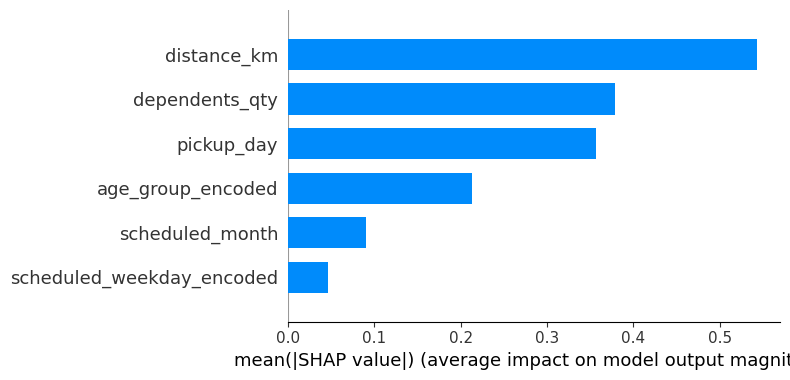

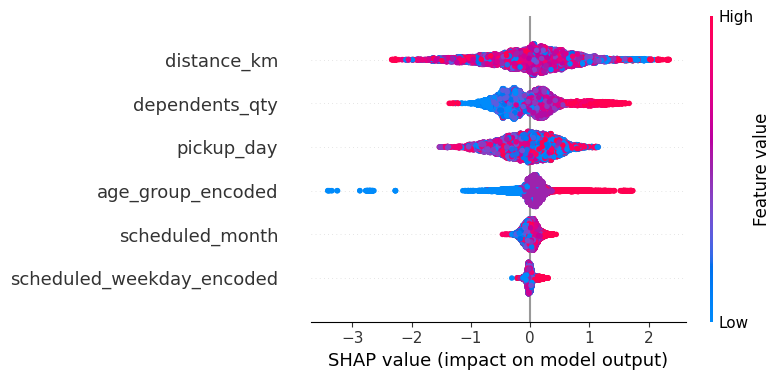

100%|===================| 15829/15883 [01:41<00:00]       

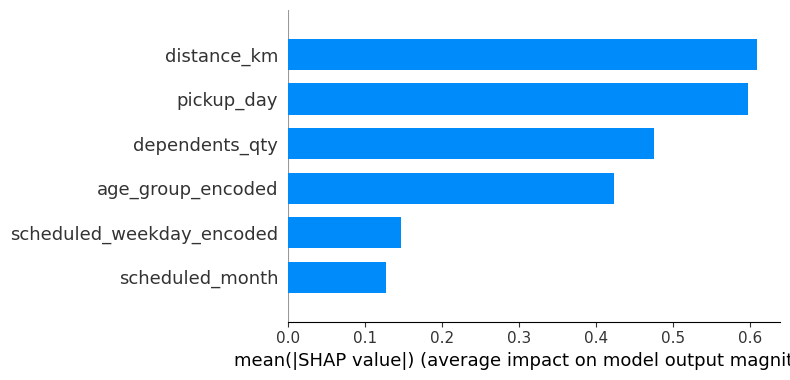

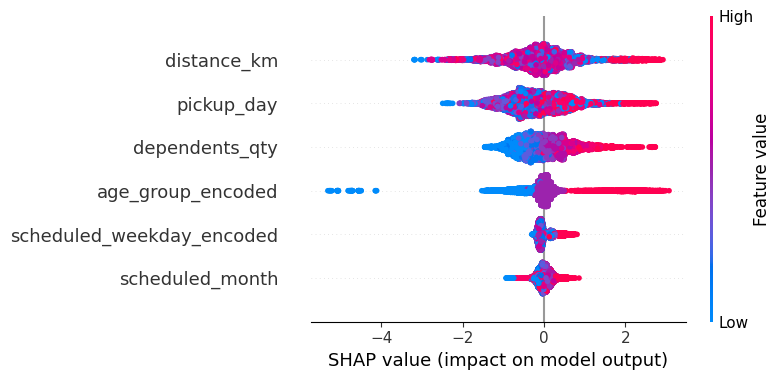

 99%|===================| 15782/15883 [01:43<00:00]       

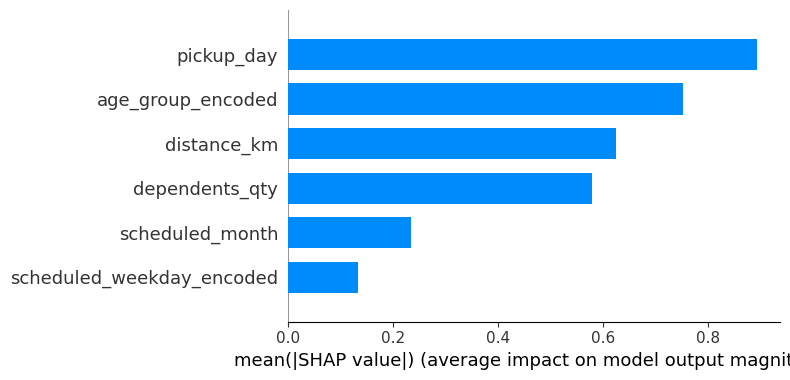

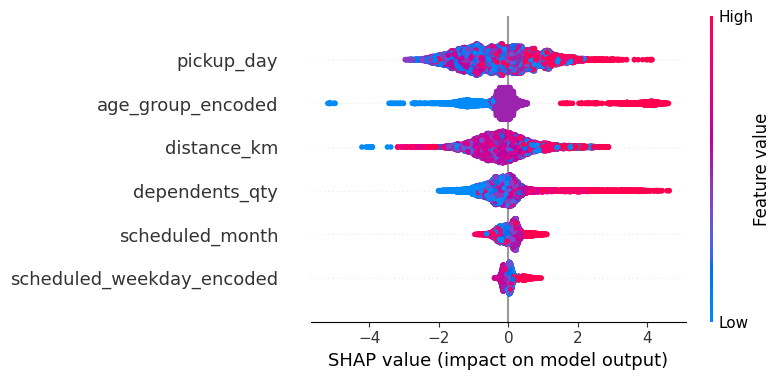

In [14]:
import shap

# 1-Month SHAP values
shap_explainer_1m = shap.Explainer(model_1m, X)
shap_values_1m = shap_explainer_1m(X)

shap.summary_plot(shap_values_1m, X, plot_type="bar")
shap.summary_plot(shap_values_1m, X)

# 3-Month SHAP values
shap_explainer_3m = shap.Explainer(model_3m, X)
shap_values_3m = shap_explainer_3m(X)

shap.summary_plot(shap_values_3m, X, plot_type="bar")
shap.summary_plot(shap_values_3m, X)

# 6-Month SHAP values
shap_explainer_6m = shap.Explainer(model_6m, X)
shap_values_6m = shap_explainer_6m(X)

shap.summary_plot(shap_values_6m, X, plot_type="bar")
shap.summary_plot(shap_values_6m, X)


# Key Insights from XAI and SHAP Reports

## 🔍 **1. Understanding How the Models Work**

These dashboards explain **binary classification models** (likely XGBoost or similar) for predicting client returns over:
- 1 month (`dashboard_1m.html`)
- 3 months (`dashboard_3m.html`)
- 6 months (`dashboard_6m.html`)

The models use **explainable AI (XAI)** through SHAP to show which features matter most and how predictions are made.

### Core Evaluation Metrics

| Metric             | 1M Model | 3M Model | 6M Model |
|--------------------|----------|----------|----------|
| Accuracy           | 0.863    | 0.877    | 0.926    |
| Precision          | 0.924    | 0.984    | 0.997    |
| Recall             | 0.861    | 0.871    | 0.924    |
| F1 Score           | 0.891    | 0.924    | 0.959    |
| ROC AUC Score      | 0.941    | 0.957    | 0.980    |
| PR AUC Score       | 0.965    | 0.992    | 0.998    |
| Log Loss           | 0.401    | 0.327    | 0.214    |

**🔎 Observation**: The model’s performance **improves** as the prediction window lengthens. One key reason is that the **data size increases** over time:
- ✅ **1-month model has the least data** → slightly lower performance and more variability in SHAP.
- ✅ **3-month model has more data** → stronger signal and stability.
- ✅ **6-month model has the most data** → best generalization and sharp confidence.

---

## 🔧 **2. Feature Importance Analysis (Mean Absolute SHAP Value)**

### 🟠 1-Month Model
Top Features:
1. `distance_km` (most impactful)
2. `dependents_qty`
3. `pickup_day`
4. `age_group_encoded`
5. `scheduled_month`
6. `scheduled_weekday_encoded`

🔹 **Interpretation**:
- Clients who live **closer** and have **dependents** are more likely to return quickly.
- **Pickup day and month** may affect whether the return is convenient.

📉 **Note**: SHAP values may be **less stable** here due to **fewer training records**—important features may appear slightly over- or under-emphasized.

---

### 🟡 3-Month Model
Top Features:
1. `distance_km`
2. `pickup_day`
3. `dependents_qty`
4. `age_group_encoded`
5. `scheduled_weekday_encoded`
6. `scheduled_month`

🔹 **Interpretation**:
- **Logistics** still dominate, but **behavioral traits** like age and scheduling start gaining weight.
- More data → **better-calibrated SHAP values**, more refined feature attributions.

---

### 🟢 6-Month Model
Top Features:
1. `pickup_day` (now most impactful)
2. `age_group_encoded`
3. `distance_km`
4. `dependents_qty`
5. `scheduled_month`
6. `scheduled_weekday_encoded`

🔹 **Interpretation**:
- Long-term return prediction is **less about distance** and **more about behavioral consistency**.
- Clients who pick up on specific days or belong to certain age groups are more likely to return in the long run.

📈 **Note**: The model benefits from a **larger dataset**, allowing SHAP to more confidently isolate consistent patterns.

---

## 🔁 **3. How Features Affect Predictions**

SHAP values explain **how much** and in **which direction** each feature pushes the model's output.

Example:
- `pickup_day = Friday` might have a **positive SHAP value** → nudges the prediction toward “will return.”
- `distance_km > 30` may have a **negative SHAP value** → reduces likelihood of return.

💡 **Deeper Insight with More Data**:
- With less data (1M), **SHAP values have more noise**.
- With more data (6M), feature effects are **more stable and generalizable**.

---

## 🧠 **4. Feature Dependence & Interaction Insights**

These dashboards let us explore:
- **Feature Dependence**: How predicted return probability shifts as a single feature (e.g., `distance_km`) changes.
- **Feature Interactions**: Reveal **combined effects** (e.g., `age_group` × `pickup_day`) that may not show up in individual SHAP plots.

Again, **more data = clearer interactions**. The 6-month model shows **stronger patterns** and **more reliable dependence curves**.

---

## 🌳 **5. Decision Trees View**

Each dashboard shows decision paths:
- These explain how the **model splits data based on key features** to arrive at a final prediction.
- With **more training data**, the tree becomes **better structured and less prone to overfitting**.

In the 1M model, paths may be shallow or inconsistent due to limited samples.

---

## 🔍 **6. Comparing the Models**

| Feature Influence Shifts | 1-Month Model         | 3-Month Model         | 6-Month Model         |
|--------------------------|-----------------------|-----------------------|-----------------------|
| Most Important Feature   | `distance_km`         | `distance_km`         | `pickup_day`          |
| Client Traits Focused    | `dependents_qty`      | `age_group_encoded`   | `age_group_encoded`   |
| Time Patterns Matter     | `scheduled_month` low | `weekday/month` rising| `weekday/month` stronger|
| Data Size                | Least data            | Medium data           | Most data             |
| SHAP Stability           | Moderate              | Better                | Strongest             |

🔹 **Summary**:
- The **short-term model** relies more on **immediate logistics** and is affected by less data.
- The **mid-range model** strikes a balance with stronger behavioral patterns.
- The **long-term model** uses **age, schedule, and habits** as strong predictors thanks to rich data and stable SHAP attributions.

---

## ✅ Conclusion

- These **XAI dashboards** allow you to **trust and interpret your models** in a clear, actionable way.
- As the time window increases, **data volume and pattern maturity** significantly improve model performance and interpretability.
- SHAP helps uncover not only what’s important, but **why and how** those features matter.
